# Using Multilayer Perceptron and Keras to predict MNIST hand written digits  

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

%matplotlib inline

plt.rcParams['figure.figsize'] = (7,7)

### Download and investigate MNIST data

In [2]:
(X_train,y_train), (X_test,y_test) = mnist.load_data()
print('Training data:', X_train.shape)
print('Test data:', X_test.shape)

11493376/11490434 [==============================] - 1s 0us/step
Training data: (60000, 28, 28)
Test data: (10000, 28, 28)


There are 60,000 training data images and 10,000 test images. Each image is 28x28 pixels.

Let's look at some of these images.

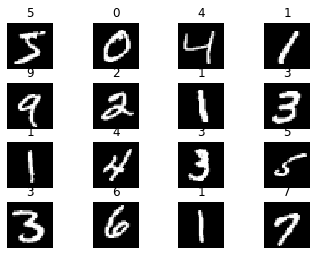

In [3]:
plt.subplots_adjust(hspace=0.3, wspace=0.1, bottom=0.1)

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title("{}".format(y_train[i]))
    plt.axis('off')
    

Check that both test and training labels are evenly distributed across all values. For example we would not want most of our training or testing data to have the same label.

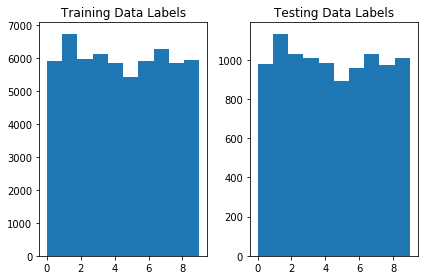

In [4]:

plt.subplot(1,2,1).hist(y_train);
plt.title('Training Data Labels');
plt.subplot(1,2,2).hist(y_test);
plt.title('Testing Data Labels');
plt.tight_layout();


### Transform the data

We apply the following transformations to the data
* convert each 28 x 28 image into a 784 dimensional vector
* rescale the values from 0-255 to 0-1. This is important so the calculations do not become unstable. For example not doing this we may end up with numbers like exp(255) which is a very large number
* convert labels into vectors using one-hot encoding. This is the format expected by the categorical_crossentropy function used later for training 

In [5]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# convert labels to vectors using one-hot encoding
Y_train = tf.keras.utils.to_categorical(y_train, 10)
Y_test = tf.keras.utils.to_categorical(y_test, 10)

Check that images still look good after transformation.

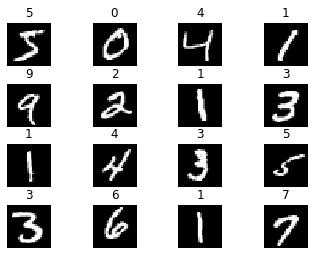

In [6]:
plt.subplots_adjust(hspace=0.4, wspace=0.1, bottom=0.1)

for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_train[i].reshape(28,28), cmap='gray')
    plt.title("{}".format(y_train[i]))
    plt.axis('off')


### Build the model

The model consists of a single fully connected hidden layer. The output layer is another fully connected layer with 10 neurons. 

The activation function used by the hidden layer, RELU, is a simple way of introducing non linerities in a neural network. Relu function defined as f(x) = max(0,x). 

**Questions:** 
* Why is it important for the activation function to introduce non linearities? 
* Assume we have a neural network with 3 hidden layers and the identity function as the activation function between layers. Does this configuration make sense?   

Dropout is a very effective technique to prevent overfitting in a neural network.

The output layer uses softmax activation becuase this can be interpreted as probability. 

In [12]:
model = Sequential([
    Dense(256, input_shape=(784,)),
    Activation('relu'),
    Dropout(0.2),
    Dense(10),
    Activation('softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               200960    
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [16]:
#it is important to specify accuracy as a metric when training for a classification problem
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


batch_size = 128
nb_classes = 10
epochs = 20

history = model.fit(X_train, Y_train,
                    batch_size=batch_size, epochs=epochs,
                    verbose=1, validation_split=0.1)


Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 2s 32us/sample - loss: 0.0150 - acc: 0.9950 - val_loss: 0.0639 - val_acc: 0.9838
Epoch 2/20
54000/54000 [==============================] - 2s 31us/sample - loss: 0.0126 - acc: 0.9960 - val_loss: 0.0703 - val_acc: 0.9852
Epoch 3/20
54000/54000 [==============================] - 2s 31us/sample - loss: 0.0109 - acc: 0.9967 - val_loss: 0.0732 - val_acc: 0.9842
Epoch 4/20
54000/54000 [==============================] - 2s 33us/sample - loss: 0.0121 - acc: 0.9962 - val_loss: 0.0739 - val_acc: 0.9830
Epoch 5/20
54000/54000 [==============================] - 2s 30us/sample - loss: 0.0099 - acc: 0.9969 - val_loss: 0.0774 - val_acc: 0.9847
Epoch 6/20
54000/54000 [==============================] - 2s 31us/sample - loss: 0.0118 - acc: 0.9962 - val_loss: 0.0669 - val_acc: 0.9842
Epoch 7/20
54000/54000 [==============================] - 2s 33us/sample - loss: 0.0101 - acc: 0.9968 - val_loss: 0.0

### Evaluate against test data

To understand how the model performs let's look at the confusion matrix. 

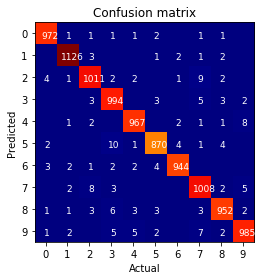

In [17]:
predicted_vectors = model.predict(X_test)
predicted_labels = np.argmax(predicted_vectors,axis=1)

cm = confusion_matrix(y_test, predicted_labels)

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Reds):
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(False)
    classes = cm.shape[0]
    plt.xticks(np.arange(classes))
    plt.yticks(np.arange(classes))
    plt.imshow(cm, cmap=plt.cm.jet, interpolation='nearest');

    for i, cas in enumerate(cm):
      for j, count in enumerate(cas):
        if count > 0:
          xoff = .07 * len(str(count))
          plt.text(j-xoff, i+.2, int(count), fontsize=9, color='white')
    
    plt.tight_layout()
        
plot_confusion_matrix(cm)   



Typical mislabelings include:
* 9 mislabeled as 4 and 9 mislabeled as 4
* 2 mislabeled as 7 and 7 mislabeled as 2

These mislabelings are not surprising and this simple model performs reasonably well.

In [18]:
score = model.evaluate(X_test, Y_test, verbose=0)
accuracy = score[1]*100
print('Test data accuracy:', accuracy,'%')

Test data accuracy: 98.29000234603882 %
